## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
%matplotlib inline

### load the dataset

In [3]:
### set your image dir here
IMAGE_DIR = "./data/"

In [4]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [5]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170
Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [6]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

./data/train/1.png


C:\Users\Luke\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\Luke\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


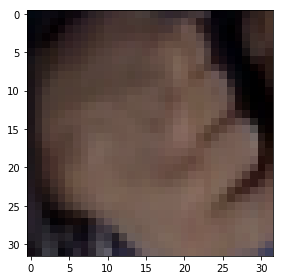

In [7]:
display(IMAGE_DIR+"train/1.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [8]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0  # weird n
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m  # batch size
        self.__max_epoch = max_epoch
        self.lastEpoch = 0
        self.L_array = []
        self.L_valarray = []
        self.accuracyTrain = []
        self.accuracyVal = []
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)  # theta value
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
    
    def fit(self, X, y, X_val=[], y_val=[]):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d
        
        if self.__init:
            self.__init_param()
        converged = False
        
        ### write your code here ### 
        for epoch in range(0,self.__max_epoch):
            eta = self.__eta0 / (self.__eta1+epoch)
            if epoch%10 == 0:
                print("Epoch:", epoch)
                print("eta:", eta)
            
            l = []
            # calculate L_old
            for image in X:
                # wtX = np.append(np.dot(self.__wt[0], image))  # sum-product of wt, X : appends float to array
                # print("products:", products)
                l.append(log(self.sigmoid(np.dot(self.__wt[0], image))))  # logLikelihood
                
            if epoch < 10:
                L_old = 5
            else:
                L_old = (-1/len(l)) * sum(l)  # average conditional logLikelihood
            
            for batch in range(X.shape[0] // self.__m):
                X_batch = X[batch*self.__m : (batch+1)*self.__m]  # X[0:15]
                y_batch = y[batch*self.__m : (batch+1)*self.__m]

                dl = []
                for image,label in zip(X_batch,y_batch):
                    dl.append(image * (label - self.sigmoid(np.dot(self.__wt[0], image))))
                  # dl.append(image * self.sigmoid(np.dot(self.__wt[0], image)))
                
                dL = (-1/len(dl)) * sum(dl)
                
                # use dL to update theta/beta/weights
                steps = eta * dL  # array of 324 updates to be applied to the 324 weights
                
                weights = self.__wt[0]
                for iteration in range(0,len(weights)):
                    weights[iteration] -= steps[iteration]
                self.__wt = [weights]

            # print("updated:", self.__wt)
            l = []
            # calculate L_new
            for image in X:
                l.append(log(self.sigmoid(np.dot(self.__wt[0], image))))  # logLikelihood
                
            L_new = (-1/len(l)) * sum(l)  # average conditional logLikelihood
            if converged:
                self.L_valarray.append(L_new)
            else:
                self.L_array.append(L_new)
            if epoch%10 == 0: print("L:", L_new)
                
            # calculate accuracy
            # train
            probTrain = self.predict_proba(X_train)
            predictionsTrain = self.predict(probTrain)
            
            correct = 0
            for prediction, label in zip(predictionsTrain, y_train):
                if prediction == label:
                    correct += 1
                    
            accuracyTrain = (correct/len(y_train)) * 100
            self.accuracyTrain.append(accuracyTrain)
            if epoch%10 == 0: print("Accuracy train:", accuracyTrain)
            
            # val
            if len(X_val) > 0:
                probVal = self.predict_proba(X_val)
                predictionsVal = self.predict(probVal)

                correct = 0
                for prediction, label in zip(predictionsVal, y_val):
                    if prediction == label:
                        correct += 1

                accuracyVal = (correct/len(y_val)) * 100
                self.accuracyVal.append(accuracyVal)
                if epoch%10 == 0: print("Accuracy val:", accuracyVal)

            # if converged, stop training
            if L_new > ((1-self.__delta)*(L_old)):
                converged = True
                self.lastEpoch = epoch
                print("BREAKING", epoch)
                print("L_new:", L_new)
                if len(X_val) == 0:
                    break
                else:
                    X = X_val
                    y = y_val
                    if len(self.L_valarray) == 0:
                        continue
                    else:
                        self.L_valarray.append(L_new)
                        print("Validation over")
                        print("epoch:", epoch)
                        break
        
        ############################
        return self.L_array
    
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
#         return a vector containing the probability values of the samples belonging to the positive class
        probabilityVector = []
        for image in X:
            probabilityVector.append(self.sigmoid(np.dot(self.__wt[0], image)))
                
        return probabilityVector
    
    def predict(self, X):
        """
        Classify the sample
        """
#       return self.predict_proba(X) >= 0.5 # attention: this will give result in bool, you need to convert it to int for submission. 
        predictions = []
    
        for prediction in X:
            if prediction >= .5:
                predictions.append(1)
            else:
                predictions.append(0)
    
        return predictions
    
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

## Question 2.3

### 1. Baseline Model

In [9]:
LR = LogisticRegression()
print("Training...")
LR.fit(X_train,y_train)
print("Finished training")

Training...
Epoch: 0
eta: 0.1
L: 0.8544496022738759
Accuracy train: 54.271725826193396
Epoch: 10
eta: 0.009090909090909092
L: 0.8333810249219074
Accuracy train: 67.52753977968176
Epoch: 20
eta: 0.004761904761904762
L: 0.8253943204226002
Accuracy train: 71.77478580171358
Epoch: 30
eta: 0.0032258064516129032
L: 0.8224149197213533
Accuracy train: 73.62301101591187
Epoch: 40
eta: 0.0024390243902439024
L: 0.821109076584571
Accuracy train: 74.82252141982863
BREAKING 41
L_new: 0.8210275467095742
Finished training


##### (a) Number of epochs till termination = 37

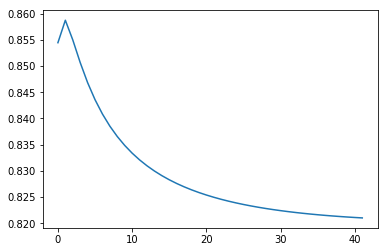

Final L: 0.8210275467095742


In [20]:
# (b) Plot L(theta) vs num_epochs
plt.plot(list(range(len(LR.L_array))), LR.L_array)
plt.show()
print("Final L:", LR.L_array[-1])

(c) Final value of L($\theta$) after optimization = .821

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [31]:
# Experimentation code goes here

# 205 epochs
# Neven = LogisticRegression(eta0=.5, eta1=.5)
# Neven.fit(X_train, y_train)
# print("Last epoch:", Neven.lastEpoch)
# print("Final L:", Neven.L_array[-1])  # .00029

# 106 epochs
# N0L = LogisticRegression(eta0=.75, eta1=.25)
# N0L.fit(X_train, y_train)
# print("Last epoch:", N0L.lastEpoch)
# print("Final L:", N0L.L_array[-1])

# .9, .1 : 20 epochs
# 1, .1 : 15 epochs
# 1, .01 : 1 epoch
Nflipped = LogisticRegression(eta0=1, eta1=.1)
Nflipped.fit(X_train, y_train)
print("Last epoch:", Nflipped.lastEpoch)
print("Final L:", Nflipped.L_array[-1])  # .00025



Epoch: 0
eta: 10.0
L: 4.605547647735463
Accuracy train: 49.96328029375765
Epoch: 10
eta: 0.09900990099009901
L: 1.3490144334791625
Accuracy train: 87.30722154222767
BREAKING 18
L_new: 1.3375592016415105
Last epoch: 18
Final L: 1.3375592016415105


(a) Best value for, $\eta_0$ = \_1_, $\eta_1$ = \_.1_

Number of epochs for training = 18

Final value of L($\theta$) = 1.321

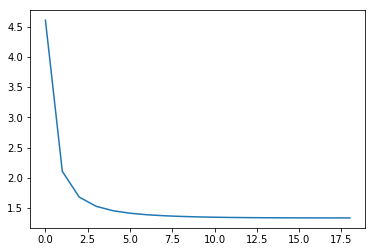

In [32]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs
plt.plot(list(range(len(Nflipped.L_array))), Nflipped.L_array)
plt.show()

### 3. Evaluating on validation set

Epoch: 0
eta: 10.0
L: 4.641570634313184
Accuracy train: 49.96328029375765
Accuracy val: 49.926578560939795
Epoch: 10
eta: 0.09900990099009901
L: 1.343614841686911
Accuracy train: 87.12362301101592
Accuracy val: 87.62848751835536
BREAKING 18
L_new: 1.3318728727184104
Epoch: 20
eta: 0.04975124378109452
L: 1.3337845899974263
Accuracy train: 87.52753977968176
Accuracy val: 87.44493392070484
Epoch: 30
eta: 0.03322259136212624
L: 1.3150196128960299
Accuracy train: 87.52753977968176
Accuracy val: 87.48164464023495
Epoch: 40
eta: 0.024937655860349125
L: 1.308059482680565
Accuracy train: 87.50305997552019
Accuracy val: 87.62848751835536
Epoch: 50
eta: 0.01996007984031936
L: 1.3051924216603574
Accuracy train: 87.41738066095472
Accuracy val: 87.62848751835536
BREAKING 54
L_new: 1.304610819118395
Validation over
epoch: 54


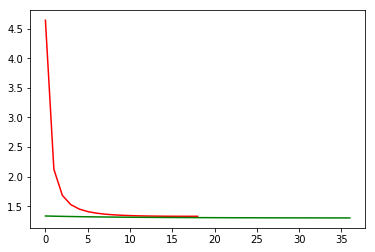

In [33]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure
Ntrainval = LogisticRegression(eta0=1, eta1=.1)
Ntrainval.fit(X_train, y_train, X_val=X_val, y_val=y_val)
plt.plot(list(range(len(Ntrainval.L_array))), Ntrainval.L_array, 'r')
plt.plot(list(range(len(Ntrainval.L_valarray))), Ntrainval.L_valarray, 'g')
plt.show()

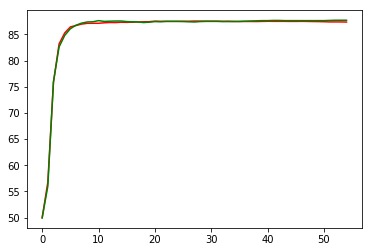

Accuracy train: 87.3561811505508
Accuracy val: 87.70190895741557


In [34]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure
plt.plot(list(range(len(Ntrainval.accuracyTrain))), Ntrainval.accuracyTrain, 'r')
plt.plot(list(range(len(Ntrainval.accuracyVal))), Ntrainval.accuracyVal, 'g')
plt.show()

print("Accuracy train:", Ntrainval.accuracyTrain[-1])
print("Accuracy val:", Ntrainval.accuracyVal[-1])



### 4. ROC and Precision-Recall curves

ROC: (array([0.        , 0.15491924, 1.        ]), array([0.        , 0.90895742, 1.        ]), array([2, 1, 0]))


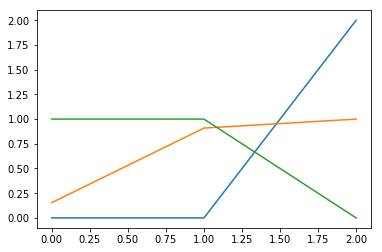

roc_auc_score: 0.8770190895741556


In [35]:
#(a) Plot ROC curve on validation data
probVal = Ntrainval.predict_proba(X_val)
y_score = Ntrainval.predict(probVal)
roc = roc_curve(y_val, y_score)
print("ROC:", roc)
plt.plot(roc)
plt.show()
print("roc_auc_score:", roc_auc_score(y_val, y_score))

Area under curve = .874

precisionRecall: (array([0.5       , 0.85438233, 1.        ]), array([1.        , 0.90895742, 0.        ]), array([0, 1]))


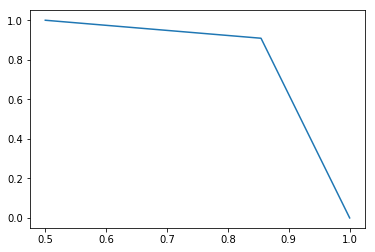

average_precision_score: 0.8221184492013834


In [36]:
#(a) Plot Precision-Recall curve on validation data
precisionRecall = precision_recall_curve(y_val, y_score)
print("precisionRecall:", precisionRecall)
precision = precisionRecall[0]
recall = precisionRecall[1]
plt.plot(precision, recall)
plt.show()
print("average_precision_score:", average_precision_score(y_val, y_score))


Average Precision = .82

## Question 2.4

### 1. Submission

In [17]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission.csv",index=0)       

#### Generate the submission.csv

In [18]:
# code goes here
probTest = Ntrainval.predict_proba(X_test)
y_pred = Ntrainval.predict(probTest)
submission(y_pred)

Best obtained accuracy on Public Leader-board = 86.214%